In [204]:
%matplotlib inline

In [195]:
from catboost import Pool, CatBoostRegressor, cv

In [196]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap

In [197]:
from sklearn.preprocessing import QuantileTransformer

In [222]:
data_all = pd.read_csv('deap_dataset_isolated.csv')
data_all

,ApEn,CREn,DiffEn,FI,Hjorth,Hurst,KFD,LZC,MSE,MSPEn,...,SFD,SVDEn,SampEn,ShanEn,SpEn,WPEn,Subj,film,ch,labels
0,1.484383,-0.007692,2.854492,0.314085,1.522358,0.193281,3.505953,0.742818,0.307039,0.987916,...,1.601542,0.824846,1.408808,12.906891,0.803484,0.999977,1,1,1,7.83
1,1.556828,-0.001690,2.903278,0.284743,1.503775,0.211067,3.861489,0.761305,0.302559,0.988604,...,1.616463,0.844913,1.465049,12.906891,0.818364,1.000000,1,1,2,7.83
2,1.585217,0.004273,2.883640,0.289118,1.580589,0.229094,3.410764,0.784833,0.303804,0.988171,...,1.601818,0.841968,1.506933,12.906891,0.811917,0.999577,1,1,3,7.83
3,1.636149,0.008965,2.644221,0.280260,1.584523,0.216789,3.376908,0.783152,0.313923,0.987522,...,1.614030,0.847914,1.555134,12.906891,0.817692,0.999983,1,1,4,7.83
4,1.829717,0.005163,3.007254,0.205972,1.549235,0.241468,3.858740,0.853737,0.290795,0.987040,...,1.630649,0.895176,1.777740,12.906891,0.843627,0.999926,1,1,5,7.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19561,1.728836,-0.004444,2.797080,0.261082,1.665462,0.247139,3.471880,0.821806,0.317735,0.988659,...,1.606150,0.860561,1.656421,12.906891,0.831258,0.999998,32,40,14,1.88
19562,1.594800,-0.055830,3.747132,0.335007,2.043562,0.331776,3.409042,0.830209,0.259786,0.987347,...,1.596723,0.810083,1.472948,12.906891,0.760206,0.999763,32,40,15,1.88
19563,1.787636,-0.016016,4.458728,0.209458,1.710900,0.373061,3.496581,0.887349,0.231478,0.986785,...,1.601611,0.893062,1.693747,12.906891,0.794703,0.999678,32,40,16,1.88
19564,1.355464,-0.034910,3.873512,0.439351,2.366161,0.372195,2.859996,0.762985,0.248196,0.987487,...,1.547087,0.730611,1.198213,12.906891,0.711782,0.999992,32,40,17,1.88


In [223]:
X_test = data_all.loc[(data_all['Subj']  == 11)].reset_index(drop=True)
X_train = data_all.loc[(data_all['Subj'] != 11)].reset_index(drop=True)
X_train = X_train.sample(frac=1)
X_test = X_test.sample(frac=1)

y_train = X_train['labels']
y_test_inv = np.array(X_test['labels'])
train_film = X_train['film']
train_subj = X_train['Subj']
train_ch = X_train['ch']
test_film = X_test['film']
test_subj = X_test['Subj']
test_ch = np.array(X_test['ch'])

X_train = X_train.drop(['film', 'labels', 'Subj'], axis=1)
X_test = X_test.drop(['film', 'labels', 'Subj'], axis=1)


qt_train = QuantileTransformer(output_distribution='normal',
                           copy=True)
y_train = pd.DataFrame(qt_train.fit_transform(np.array(y_train).reshape(-1, 1)))
qt_test = QuantileTransformer(output_distribution='normal',
                             copy=True)
y_test = pd.DataFrame(qt_test.fit_transform(np.array(y_test_inv).reshape(-1, 1)))

In [ ]:
model = CatBoostRegressor()
model.fit(X_train, y_train, cat_features=['ch'])

In [225]:
y_pred = model.predict(X_test)

In [226]:
preds = qt_test.inverse_transform(y_pred.reshape(-1, 1))

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

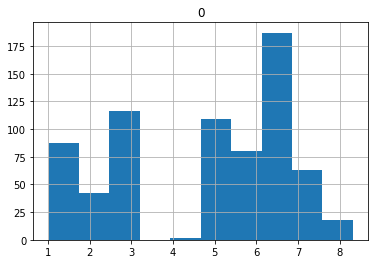

In [227]:
pd.DataFrame(preds).hist()

In [228]:
pd.DataFrame(preds).describe()

,0
count,704.000000
mean,4.750109
std,2.011480
min,1.010000
25%,2.780000
50%,5.190000
75%,6.274154
max,8.320000


In [229]:
n_subjects = 32
n_films = 40
pred = [[0 for j in range(n_films)] for i in range(n_subjects)]
num_chans = [[0 for j in range(n_films)] for i in range(n_subjects)]
labels = [[0 for j in range(n_films)] for i in range(n_subjects)]
lbl = [[0 for j in range(n_films)] for i in range(n_subjects)]
channels = [[] for i in range(n_subjects)]
for i in range(len(preds)):
    pred[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += np.array(preds)[i]
    num_chans[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += 1
    labels[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += np.array(y_test_inv)[i]
    channels[np.array(test_subj)[i] - 1].append(chans[test_ch[i] - 1])
labels = np.array(labels).astype(np.float64) / np.array(num_chans).astype(np.float64)
pred = np.array(pred).astype(np.float64) / np.array(num_chans).astype(np.float64)
labels = np.nan_to_num(labels)
pred = np.nan_to_num(pred)
predicted = []
lbl = []
for i in range(len(labels)):
    if sum(labels[i]) != 0:
        for j in range(n_films):
            if labels[i][j] != 0:
                lbl.append(labels[i][j])  
                predicted.append(pred[i][j])

In [230]:
for [l, p] in zip(lbl, predicted):
    print('label : {:0.2f} predicted: {:0.2f} '.format(l, p))

label : 6.50 predicted: 5.65 
label : 5.63 predicted: 5.36 
label : 6.27 predicted: 1.68 
label : 7.06 predicted: 3.33 
label : 6.68 predicted: 5.68 
label : 2.78 predicted: 5.88 
label : 6.22 predicted: 6.38 
label : 6.10 predicted: 6.40 
label : 8.32 predicted: 4.10 
label : 2.36 predicted: 6.46 
label : 5.19 predicted: 5.41 
label : 1.37 predicted: 5.62 
label : 7.69 predicted: 5.47 
label : 6.03 predicted: 6.58 
label : 3.04 predicted: 4.92 
label : 1.79 predicted: 3.56 
label : 6.19 predicted: 5.36 
label : 7.08 predicted: 3.46 
label : 5.06 predicted: 6.03 
label : 1.00 predicted: 2.27 
label : 6.31 predicted: 4.05 
label : 6.40 predicted: 5.85 
label : 6.95 predicted: 3.37 
label : 1.33 predicted: 5.55 
label : 2.53 predicted: 2.18 
label : 6.18 predicted: 3.33 
label : 2.90 predicted: 6.79 
label : 6.78 predicted: 3.38 
label : 1.55 predicted: 2.84 
label : 1.00 predicted: 5.69 
label : 5.01 predicted: 6.54 
label : 7.10 predicted: 5.89 
label : 1.24 predicted: 5.92 
label : 1.

In [231]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

In [232]:
print('r2:', r2_score(lbl, predicted))
print('MAPE:', mean_absolute_percentage_error(lbl, predicted))
print('MAE : ', mean_absolute_error(lbl, predicted))

r2: -0.2776590339520766
MAPE: 1.0667531452659635
MAE :  2.2725919920394597


## Таблица со значениями метрик

In [238]:
data_all

,ApEn,CREn,DiffEn,FI,Hjorth,Hurst,KFD,LZC,MSE,MSPEn,...,SFD,SVDEn,SampEn,ShanEn,SpEn,WPEn,Subj,film,ch,labels
0,1.484383,-0.007692,2.854492,0.314085,1.522358,0.193281,3.505953,0.742818,0.307039,0.987916,...,1.601542,0.824846,1.408808,12.906891,0.803484,0.999977,1,1,1,7.83
1,1.556828,-0.001690,2.903278,0.284743,1.503775,0.211067,3.861489,0.761305,0.302559,0.988604,...,1.616463,0.844913,1.465049,12.906891,0.818364,1.000000,1,1,2,7.83
2,1.585217,0.004273,2.883640,0.289118,1.580589,0.229094,3.410764,0.784833,0.303804,0.988171,...,1.601818,0.841968,1.506933,12.906891,0.811917,0.999577,1,1,3,7.83
3,1.636149,0.008965,2.644221,0.280260,1.584523,0.216789,3.376908,0.783152,0.313923,0.987522,...,1.614030,0.847914,1.555134,12.906891,0.817692,0.999983,1,1,4,7.83
4,1.829717,0.005163,3.007254,0.205972,1.549235,0.241468,3.858740,0.853737,0.290795,0.987040,...,1.630649,0.895176,1.777740,12.906891,0.843627,0.999926,1,1,5,7.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19561,1.728836,-0.004444,2.797080,0.261082,1.665462,0.247139,3.471880,0.821806,0.317735,0.988659,...,1.606150,0.860561,1.656421,12.906891,0.831258,0.999998,32,40,14,1.88
19562,1.594800,-0.055830,3.747132,0.335007,2.043562,0.331776,3.409042,0.830209,0.259786,0.987347,...,1.596723,0.810083,1.472948,12.906891,0.760206,0.999763,32,40,15,1.88
19563,1.787636,-0.016016,4.458728,0.209458,1.710900,0.373061,3.496581,0.887349,0.231478,0.986785,...,1.601611,0.893062,1.693747,12.906891,0.794703,0.999678,32,40,16,1.88
19564,1.355464,-0.034910,3.873512,0.439351,2.366161,0.372195,2.859996,0.762985,0.248196,0.987487,...,1.547087,0.730611,1.198213,12.906891,0.711782,0.999992,32,40,17,1.88


In [233]:
from tqdm import tqdm_notebook

In [235]:
models = ['CatboostRegressor']
metrics = ['MAPE', 'MAE', 'R2']
formes = ['inverted', 'average']
columns = [
    np.array([models[i] for i in range(1) for j in range(3) for k in range(2)]),
    np.array([metrics[j] for i in range(1) for j in range(3) for k in range(2)]),
    np.array([formes[k] for i in range(1) for j in range(3) for k in range(2)]),
]

In [ ]:
result = pd.DataFrame()
grid_res = []
n_films = 40
n_subjects = 32
for film in tqdm_notebook(range(1, n_films + 1)):
    df = pd.DataFrame(np.random.randn(1, 1 * 3 * 2), columns=columns)
    X_test = data_all.loc[(data_all['film'] == film)].reset_index(drop=True)
    X_train = data_all.loc[(data_all['film'] != film)].reset_index(drop=True)
    X_train = X_train.sample(frac=1)
    X_test = X_test.sample(frac=1)

    y_train = X_train['labels']
    y_test_inv = np.array(X_test['labels'])
    train_film = X_train['film']
    train_subj = X_train['Subj']
    train_ch = X_train['ch']
    test_film = X_test['film']
    test_subj = X_test['Subj']
    test_ch = np.array(X_test['ch'])
    
    X_train = X_train.drop(['film', 'Subj', 'labels'], axis=1)
    X_test = X_test.drop(['film', 'Subj', 'labels'], axis=1)
    
    qt_train = QuantileTransformer(output_distribution='normal',
                             copy=True)
    y_train = pd.DataFrame(qt_train.fit_transform(np.array(y_train).reshape(-1, 1)))
    qt_test = QuantileTransformer(output_distribution='normal',
                             copy=True)
    y_test = pd.DataFrame(qt_test.fit_transform(np.array(y_test_inv).reshape(-1, 1)))
    
    train_pool = Pool(X_train, y_train, cat_features=['ch'])
    test_pool = Pool(X_test, y_test, cat_features=['ch'])
    model = CatBoostRegressor()
    model.fit(train_pool)
    y_pred = model.predict(test_pool)
    preds = qt_test.inverse_transform(np.array(y_pred).reshape(-1, 1))
    df[('CatboostRegressor', 'R2', 'inverted')] = r2_score(preds, y_test_inv)
    df[('CatboostRegressor', 'MAPE', 'inverted')] = mean_absolute_percentage_error(preds, y_test_inv)
    df[('CatboostRegressor', 'MAE', 'inverted')] = mean_absolute_error(preds, y_test_inv)
    
    pred = [[0 for j in range(n_films)] for i in range(n_subjects)]
    num_chans = [[0 for j in range(n_films)] for i in range(n_subjects)]
    labels = [[0 for j in range(n_films)] for i in range(n_subjects)]
    lbl = [[0 for j in range(n_films)] for i in range(n_subjects)]
    channels = [[] for i in range(n_subjects)]
    for i in range(len(preds)):
        pred[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += preds[i]
        num_chans[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += 1
        labels[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += y_test_inv[i]
        channels[np.array(test_subj)[i] - 1].append(chans[test_ch[i] - 1])
    labels = np.array(labels).astype(np.float64) / np.array(num_chans).astype(np.float64)
    pred = np.array(pred).astype(np.float64) / np.array(num_chans).astype(np.float64)
    labels = np.nan_to_num(labels)
    pred = np.nan_to_num(pred)
    predicted = []
    lbl = []
    for i in range(len(labels)):
        if sum(labels[i]) != 0:
            for j in range(n_films):
                if labels[i][j] != 0:
                    lbl.append(labels[i][j])  
                    predicted.append(pred[i][j])

    df[('CatboostRegressor', 'R2', 'average')] = r2_score(lbl, predicted)
    df[('CatboostRegressor', 'MAPE', 'average')] = mean_absolute_percentage_error(lbl, predicted)
    df[('CatboostRegressor', 'MAE', 'average')] = mean_absolute_error(lbl, predicted)
    result = pd.concat([result, df], axis=0)

In [241]:
result

CatboostRegressor                                                  
               MAPE                 MAE                  R2          
           inverted   average  inverted   average  inverted   average
0          0.197009  0.272956  1.263896  1.211844 -3.641269  0.031174
0          0.228968  0.338143  1.416229  1.291550 -4.525942  0.061670
0          0.174940  0.172090  1.105614  1.003930 -1.961647 -0.248891
0          0.220224  0.271573  1.236938  1.196226 -1.706404  0.005061
0          0.345290  0.559827  1.870106  1.753972 -2.351685 -0.249749
0          0.220233  0.450661  1.333805  1.336842 -5.497815  0.118275
0          0.288459  0.634715  1.567274  1.527151 -3.911118  0.053965
0          0.183816  0.264499  1.225693  1.186940 -6.346443 -0.022044
0          0.200343  0.219870  1.363548  1.279999 -3.741685 -0.198773
0          0.358491  0.665434  1.934102  1.810996 -3.081078 -0.281526
0          0.158254  0.155459  1.059428  0.883726 -2.405223  0.101402
0          0.214930  0.341519  1.289145  1.208376 -6.331328  0.127968
0          0.210528  0.311170  1.375296  1.277306 -4.213333 -0.006088
0          0.144411  0.142473  1.052717  0.998109 -2.539739 -0.003185
0          0.300389  0.379994  1.504803  1.455494 -2.515763  0.167476
0          0.288515  0.361769  1.487684  1.387291 -1.581081  0.089122
0          0.249270  0.399396  1.445594  1.438855 -3.741194  0.039050
0          0.132528  0.152635  0.922553  0.895843 -3.533367 -0.005622
0          0.166498  0.222582  1.142633  1.142716 -4.685067 -0.191791
0          0.338459  0.508446  1.808329  1.738746 -3.272282  0.056913
0          0.390383  0.696777  1.683516  1.602556 -1.611533  0.053218
0          0.360757  0.362474  1.658009  1.541866 -2.740683 -0.112584
0          0.366403  0.525517  1.710356  1.668923 -2.360882 -0.048878
0          0.247660  0.367072  1.308710  1.320580 -3.432994 -0.036464
0          0.300144  0.391548  1.613868  1.545529 -2.371828 -0.119535
0          0.316515  0.450117  1.712177  1.664347 -4.435097 -0.003525
0          0.319615  0.517330  1.779981  1.631936 -4.201117 -0.101273
0          0.194481  0.439899  1.098229  1.176513 -5.246208 -0.149413
0          0.290570  0.318311  1.572753  1.372295 -1.957044  0.215638
0          0.202933  0.368794  1.276790  1.176390 -6.430030 -0.086885
0          0.336160  0.586068  1.763856  1.780678 -3.034266 -0.071808
0          0.500216  1.197096  2.218645  2.260174 -2.864240 -0.248208
0          0.881583  0.852908  1.872033  1.737577 -2.017415 -0.181026
0          0.816735  0.688214  1.763893  1.710960 -3.098291 -0.181563
0          0.628475  0.667939  1.662666  1.444324 -2.382355  0.094775
0          0.626256  0.542554  2.018825  1.930606 -3.298451 -0.166330
0          0.831901  0.592946  1.448309  1.405713 -3.097646  0.010958
0          1.092225  0.603181  1.648694  1.638263 -4.188421 -0.187655
0          0.808786  0.689462  1.630303  1.603116 -2.450215 -0.067692
0          0.483783  0.659724  1.871041  1.824499 -2.028385  0.039440

In [242]:
result.to_excel('metrics_deap.xlsx')

In [243]:
result.describe()

CatboostRegressor                                                       
                   MAPE                   MAE                    R2           
               inverted    average   inverted    average   inverted    average
count         40.000000  40.000000  40.000000  40.000000  40.000000  40.000000
mean           0.365428   0.458579   1.517951   1.451569  -3.370764  -0.042610
std            0.232924   0.215507   0.299622   0.298528   1.309609   0.126866
min            0.132528   0.142473   0.922553   0.883726  -6.430030  -0.281526
25%            0.208630   0.316526   1.286056   1.210977  -4.191595  -0.153642
50%            0.295357   0.419648   1.536038   1.441589  -3.097968  -0.014066
75%            0.372398   0.595505   1.725097   1.665491  -2.379724   0.053405
max            1.092225   1.197096   2.218645   2.260174  -1.581081   0.215638

In [244]:
result.describe().to_excel('metrics_deap_described.xlsx')

In [245]:
params = {'depth': 6, 'l2_leaf_reg': 3, 'iterations': 1000, 'learning_rate': 0.1, 'loss_function' : 'RMSE'}

In [246]:
import warnings
import logging
warnings.filterwarnings('ignore')

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
logging.getLogger("shap").setLevel(logging.WARNING)

## Таблицы со значениями shap для всех фильмов (1 на тест, остальные на обучение)

In [ ]:
chans = ['Fz', 'F3', 'F7','C3', 'T7', 'Pz', 'P3','P7', 'O1', 'Oz', 'O2','P4', 'P8', 'Cz','C4', 'T8', 'F4', 'F8']
result = pd.DataFrame()
grid_res = []
n_films = 40
for film in tqdm_notebook(range(1, n_films + 1)):
    X_test = data_all.loc[(data_all['film'] == film)].reset_index(drop=True)
    X_train = data_all.loc[(data_all['film'] != film)].reset_index(drop=True)
    X_train = X_train.sample(frac=1)
    X_test = X_test.sample(frac=1)

    y_train = X_train['labels']
    y_test = np.array(X_test['labels'])
    train_film = X_train['film']
    train_subj = X_train['Subj']
    train_ch = X_train['ch']
    test_film = X_test['film']
    test_subj = X_test['Subj']
    test_ch = np.array(X_test['ch'])
    
    X_train = X_train.drop(['film', 'Subj', 'labels', 'ch'], axis=1)
    X_test = X_test.drop(['film', 'Subj', 'labels', 'ch'], axis=1)
    
    
    train_pool = Pool(X_train, y_train)
    test_pool = Pool(X_test, y_test)
    model = CatBoostRegressor()
    model.fit(train_pool)
    X_train_summary = shap.kmeans(X_train, 10)
    explainer = shap.KernelExplainer(model.predict, X_train_summary)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, max_display=23, show=False)
    plt.savefig('F{}_deap.png'.format(film),  bbox_inches='tight')
    plt.clf()